<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

In [200]:
# from google.colab import files
# from os.path import exists
# file_exists = exists("/content/kaggle.json")
# if (file_exists==False):
#   files.upload()

In [201]:
%cd /content/drive/MyDrive/Colab Notebooks/Titanic

/content/drive/MyDrive/Colab Notebooks/Titanic


In [202]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [203]:
 ! kaggle competitions download titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


Start To work on geting data

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
import copy

In [205]:
# Load Data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check For Nulls


In [206]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [207]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check Data Types

In [208]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [209]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Data Scrubing Replacing NAN values

In [210]:
# from source 2
# Replace NAN
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

# Test Replace
test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [211]:
# source 1
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string) # For debug check
    return np.nan
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
# Apply function to data
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)


In [212]:
# data check
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr


In [213]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr


In [214]:
# Make cabin type
# Source 2
train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# Make New Label
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [215]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U,1


In [216]:
# data check 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss,U,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs,U,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr,U,3


The correlation bellow shows that Family size is not linearly related however there is a relationship between survival and family size

In [217]:
# make encoded values
encode_vals = ['Sex','Cabin_type','Embarked','Title']
def make_encode_num(val, data):
  for feature in val:
    data[feature]=data[feature].astype('category')
    data[feature+'_value']=data[feature].cat.codes
  return data
train=make_encode_num(encode_vals, train)
test = make_encode_num(encode_vals, test)

In [218]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2,1,8,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1,0,8,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0,2,2,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U,1,1,8,2,2


In [219]:
# data check
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1,1,7,1,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2,0,7,2,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss,U,1,1,7,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs,U,1,1,7,2,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr,U,3,0,7,2,2


In [220]:
# make one hot encoding
# I only relized after I made the function how bad the naming was
def one_hot(data, labels):
  for label in labels:
    temp = data[label]
    data= pd.get_dummies(data, columns=[label])
    data[label]=temp
  return data
temp = copy.copy(train)
temp=one_hot(temp, encode_vals)
temp.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value,Sex_female,Sex_male,Sex,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_U,Cabin_type,Embarked_C,Embarked_Q,Embarked_S,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Unknown,2,1,8,2,2,0,1,male,0,0,0,0,0,0,0,0,1,U,0,0,1,S,0,0,1,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,2,0,2,0,3,1,0,female,0,0,1,0,0,0,0,0,0,C,1,0,0,C,0,0,0,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Unknown,1,0,8,2,1,1,0,female,0,0,0,0,0,0,0,0,1,U,0,0,1,S,0,1,0,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,2,0,2,2,3,1,0,female,0,0,1,0,0,0,0,0,0,C,0,0,1,S,0,0,0,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Unknown,1,1,8,2,2,0,1,male,0,0,0,0,0,0,0,0,1,U,0,0,1,S,0,0,1,0,Mr


In [221]:
#temp.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

## Survival Factors

In [222]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived              1.000000
Sex_value            -0.543351
Pclass               -0.338481
Cabin_type_value     -0.301116
Fare                  0.257307
Embarked_value       -0.167675
Parch                 0.081629
Age                  -0.069809
Title_value          -0.062139
SibSp                -0.035322
family_member_size    0.016639
PassengerId          -0.005007
Name: Survived, dtype: float64

In [223]:
# See what index Does
# index gives the feature values that equaled true
l=list(train.corr()[train.corr()["Survived"].abs()>.05] )
p=list(train.corr()[train.corr()["Survived"].abs()>.05].index )
print(len(l),"\n",l)
print(len(p),"\n",p)
res = [x for x in l + p if x not in l or x not in p]
print(res)

12 
 ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'family_member_size', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value']
9 
 ['Survived', 'Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value']
['PassengerId', 'SibSp', 'family_member_size']


In [224]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value', 'Title_value']


# Exploratory Data Analysis For Survival

In [225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         891 non-null    int64   
 1   Survived            891 non-null    int64   
 2   Pclass              891 non-null    int64   
 3   Name                891 non-null    object  
 4   Sex                 891 non-null    category
 5   Age                 891 non-null    float64 
 6   SibSp               891 non-null    int64   
 7   Parch               891 non-null    int64   
 8   Ticket              891 non-null    object  
 9   Fare                891 non-null    float64 
 10  Cabin               891 non-null    object  
 11  Embarked            891 non-null    category
 12  Title               891 non-null    category
 13  Cabin_type          891 non-null    category
 14  family_member_size  891 non-null    int64   
 15  Sex_value           891 non-null    int8

In [226]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Title_value
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.904602,0.647587,6.716049,1.536476,1.860831
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,1.613459,0.477990,2.460739,0.791503,0.721066
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,8.000000,1.000000,2.000000
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,1.000000,1.000000,8.000000,2.000000,2.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,8.000000,2.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000,8.000000,2.000000,3.000000


## Survival by Cabin Type

In [246]:
train.groupby("Cabin_type")["Survived"].mean()

Cabin_type
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
U    0.299854
Name: Survived, dtype: float64

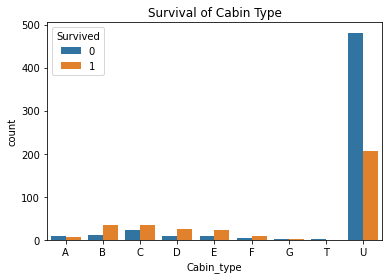

In [244]:
sns.countplot(x="Cabin_type",hue="Survived", data=train)
plt.title("Survival of Cabin Type")
plt.show()

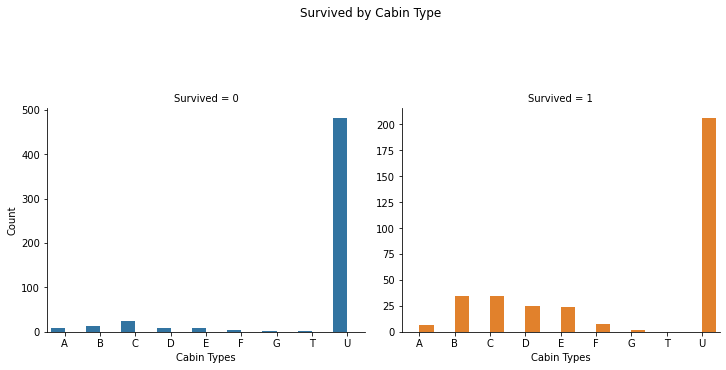

In [248]:
cabin_type_plot= sns.catplot(x="Cabin_type", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
cabin_type_plot.fig.subplots_adjust(top=0.7)
cabin_type_plot.fig.suptitle("Survived by Cabin Type")
cabin_type_plot.set_xlabels("Cabin Types")
cabin_type_plot.set_ylabels("Count")
plt.show()

## Survival by Pclass

In [230]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

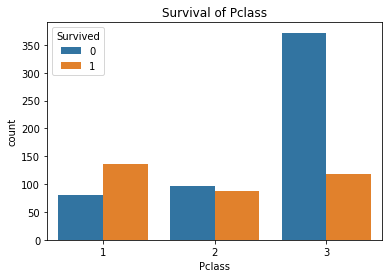

In [231]:
sns.countplot(x="Pclass",hue="Survived", data=train)
plt.title("Survival of Pclass")
plt.show()

## Survival by Sex

In [232]:
train.groupby("Pclass")["Survived"].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

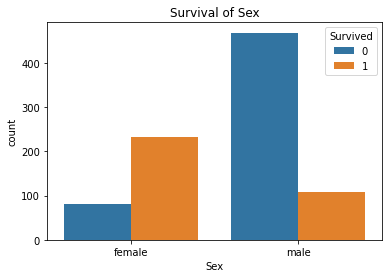

In [233]:
sns.countplot(x="Sex",hue="Survived", data=train)
plt.title("Survival of Sex")
plt.show()

## Survival by Age

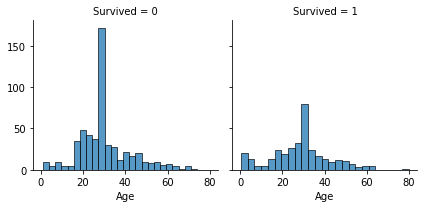

In [234]:
sns.FacetGrid(train, col="Survived").map(sns.histplot, "Age", bins=25)
plt.show()

## Survial by Sibsp

In [235]:
train.groupby("SibSp")["Survived"].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

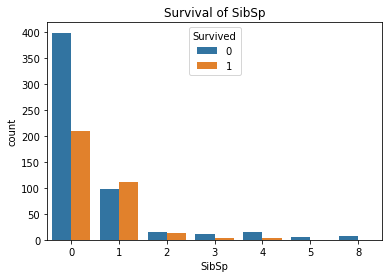

In [236]:
sns.countplot(x="SibSp",hue="Survived", data=train)
plt.title("Survival of SibSp")
plt.show()

## Survival by Parch

In [237]:
train.groupby("Parch")["Survived"].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

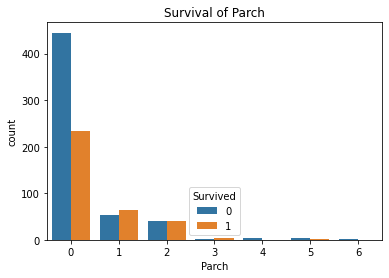

In [238]:
sns.countplot(x="Parch",hue="Survived", data=train)
plt.title("Survival of Parch")
plt.show()


## Survival by Fare


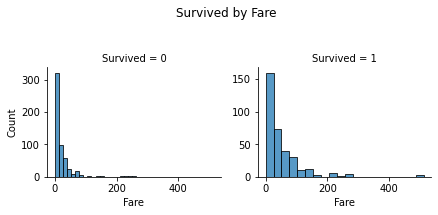

In [239]:
Fare_plot=sns.FacetGrid(train, col="Survived", sharey=False)
Fare_plot.map(sns.histplot, "Fare",bins=20)
Fare_plot.fig.subplots_adjust(top=0.7)
Fare_plot.fig.suptitle("Survived by Fare")
Fare_plot.set_xlabels("Fare")
Fare_plot.set_ylabels("Count")
plt.show()

## Survival by Embarked


In [240]:
train.groupby("Embarked")["Survived"].mean()

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64

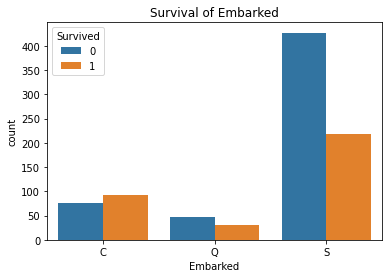

In [241]:
sns.countplot(x="Embarked",hue="Survived",data=train)
plt.title("Survival of Embarked")
plt.show()

## Survived by Title

In [242]:
train.groupby("Title")["Survived"].mean()

Title
Master    0.575000
Miss      0.703297
Mr        0.158192
Mrs       0.775362
Name: Survived, dtype: float64

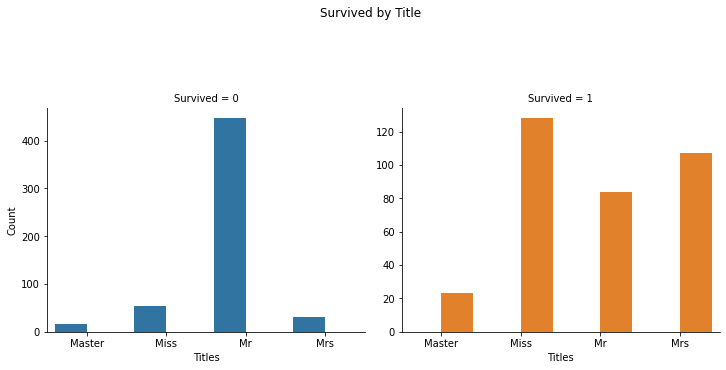

In [249]:
title_plot= sns.catplot(x="Title", hue="Survived", col="Survived", data=train, kind="count", sharey=False)
title_plot.fig.subplots_adjust(top=0.7)
title_plot.fig.suptitle("Survived by Title")
title_plot.set_xlabels("Titles")
title_plot.set_ylabels("Count")
plt.show()

In [250]:
train.max()

PassengerId                                   891
Survived                                        1
Pclass                                          3
Name                  van Melkebeke, Mr. Philemon
Age                                            80
SibSp                                           8
Parch                                           6
Ticket                                  WE/P 5735
Fare                                      512.329
Cabin                                     Unknown
family_member_size                             11
Sex_value                                       1
Cabin_type_value                                8
Embarked_value                                  2
Title_value                                     3
dtype: object

## Deep and Wide

In [ ]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex_value', vocabulary_list=(0, 1), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked_value', vocabulary_list=(0, 1, 2), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Cabin_type_value', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8), dtype=tf.int8, default_value=-1, num_oov_buckets=0))]


In [ ]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(features_and_labels)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
  # print(dataset)
    dataset = dataset.prefetch(1)
  # print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [ ]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

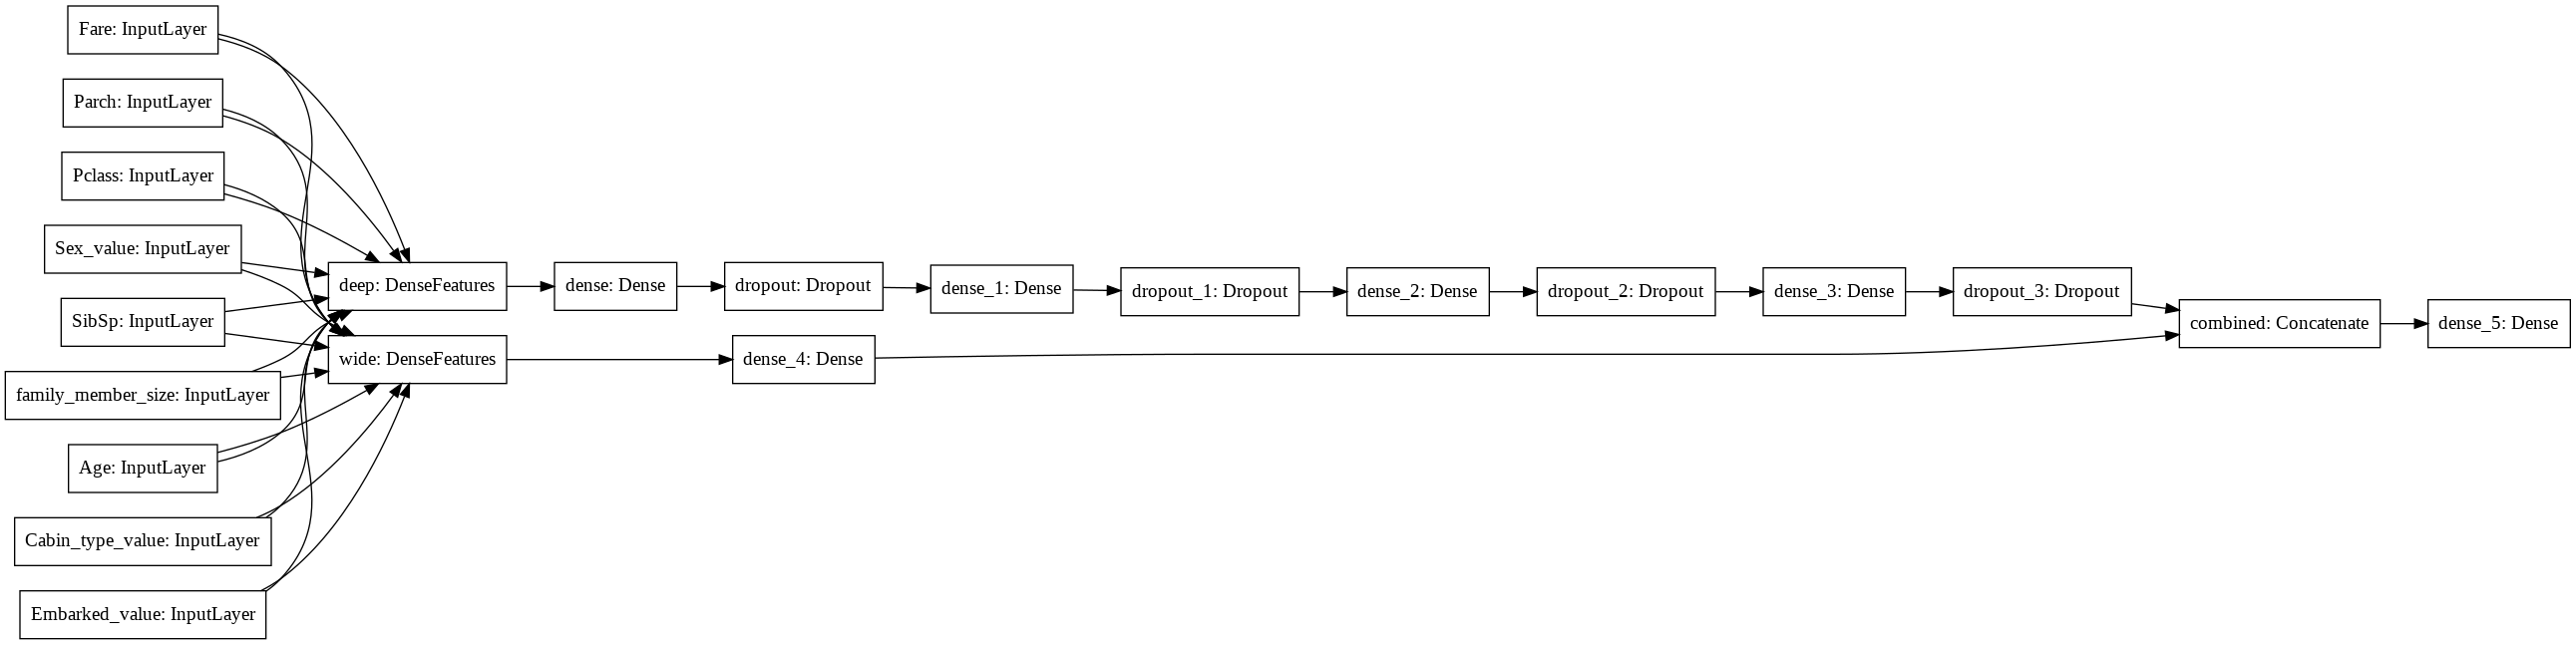

In [ ]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

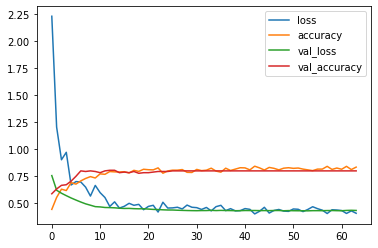

In [ ]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [ ]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
# print("y_pred", y_pred)
print("Accuracy score:", score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
print(Survived.shape)

Accuracy score: 0.5642458100558659
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       109
           1       0.42      0.31      0.36        70

    accuracy                           0.56       179
   macro avg       0.52      0.52      0.52       179
weighted avg       0.54      0.56      0.55       179

(418,)
